In [43]:
import numpy as np
from PIL import Image
import os
import pandas as pd
import scipy
from matplotlib import cm as CM
import json
import scipy.ndimage
import h5py

In [11]:
labels = pd.read_csv('armatura_croped/labels/labels.csv')
labels = labels[labels.region_shape_attributes != '{}']
labels.head()

,#filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,armatura-16-mm-gost_2_1.jpg,17051,{},178,0,"{""name"":""point"",""cx"":207,""cy"":154}",{}
1,armatura-16-mm-gost_2_1.jpg,17051,{},178,1,"{""name"":""point"",""cx"":195,""cy"":150}",{}
2,armatura-16-mm-gost_2_1.jpg,17051,{},178,2,"{""name"":""point"",""cx"":188,""cy"":142}",{}
3,armatura-16-mm-gost_2_1.jpg,17051,{},178,3,"{""name"":""point"",""cx"":180,""cy"":136}",{}
4,armatura-16-mm-gost_2_1.jpg,17051,{},178,4,"{""name"":""point"",""cx"":170,""cy"":144}",{}


In [13]:
all_armatures = [i for i in os.listdir('armatura_croped/') if i.endswith('.jpg') or i.endswith('.jpeg')]
main_path = 'armatura_croped/'

In [14]:
# get coordiantes of armatures

image_points = []
for j in range(len(all_armatures)):
    
    cx = []
    cy = []
    for i in labels[labels['#filename'] == all_armatures[j]]['region_shape_attributes']:
        i = json.loads(i)
        cx.append(i['cx'])
        cy.append(i['cy'])
            
    image_points.append([cx, cy])

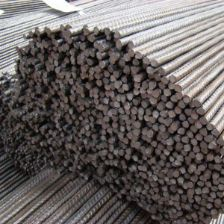

In [16]:
# image example
Image.open(main_path + all_armatures[-2])

In [26]:
# transform them to correct view
new_points_imgs = []
for xy_point in image_points:
    arr = []
    for j in range(len(xy_point[0])):
        arr.append([xy_point[0][j], xy_point[1][j]])

    new_points_imgs.append(arr)

# Generating density map

In [38]:
# Generates a density map using Gaussian filter transformation
def gaussian_filter_density(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    
    gt_count = np.count_nonzero(gt)
    
    if gt_count == 0:
        return density

    # FInd out the K nearest neighbours using a KDTree
    
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    leafsize = 2048
    
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    
    # query kdtree
    distances, locations = tree.query(pts, k=4)

        
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        
        #Convolve with the gaussian filter
        
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    
    return density


from tqdm import tqdm

i = 0
counter = 0
img_paths = [main_path + i for i in all_armatures]
h5_path = 'armatura_croped/hdf5/'
for img_path in tqdm(img_paths):
           
    #Read image
    img= plt.imread(img_path)
    
    # Create a zero matrix of image size
    k = np.zeros((img.shape[0],img.shape[1]))
    
    gt = new_points_imgs[counter]
    
    #Generate hot encoded matrix of sparse matrix
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    
    # generate density map
    k = gaussian_filter_density(k)
    
    # File path to save density map
    file_path = h5_path + img_path.split('/')[-1].replace('.jpg','.h5').replace('.jpeg', '.h5')
    
    
    with h5py.File(file_path, 'w') as hf:
            hf['density'] = k
        
    counter += 1
    

100%|██████████| 24/24 [00:06<00:00,  3.00it/s]


Sum =  169.00002


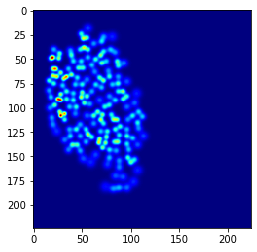

In [46]:
file_path = os.listdir(h5_path)
gt_file = h5py.File(h5_path + file_path[0],'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)
print("Sum = " ,np.sum(groundtruth))